In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
file = tf.keras.utils
raw_features=pd.read_csv("https://media.githubusercontent.com/media/GuyenSoto/BTC/master/elliptic_txs_features.csv")
raw_classes=pd.read_csv("https://media.githubusercontent.com/media/GuyenSoto/BTC/master/elliptic_txs_classes.csv")
raw_edgelist=pd.read_csv("https://media.githubusercontent.com/media/GuyenSoto/BTC/master/elliptic_txs_edgelist.csv")


In [4]:
#feat=raw_features.copy()
#clase=raw_classes.copy()
#edge=raw_edgelist.copy()

In [5]:
raw_classes['class'].value_counts()

unknown    157205
2           42019
1            4545
Name: class, dtype: int64

In [6]:
# renaming columns
raw_features.columns = ['id', 'time'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
raw_features.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,...,agg_feat_32,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.077909,-0.093120,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.1

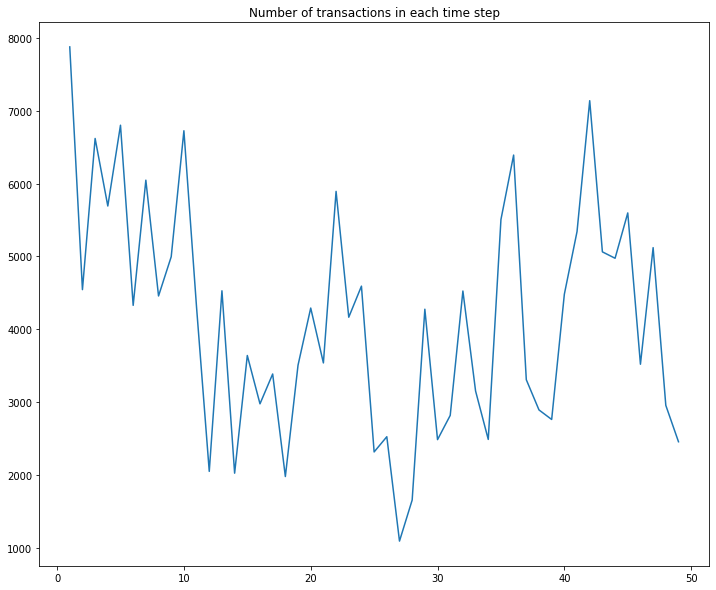

In [7]:
raw_features['time'].value_counts().sort_index().plot();
plt.title('Number of transactions in each time step');

In [8]:
# merge with classes
raw_features = pd.merge(raw_features, raw_classes, left_on='id', right_on='txId', how='left')
cleaned_df = raw_features.copy()

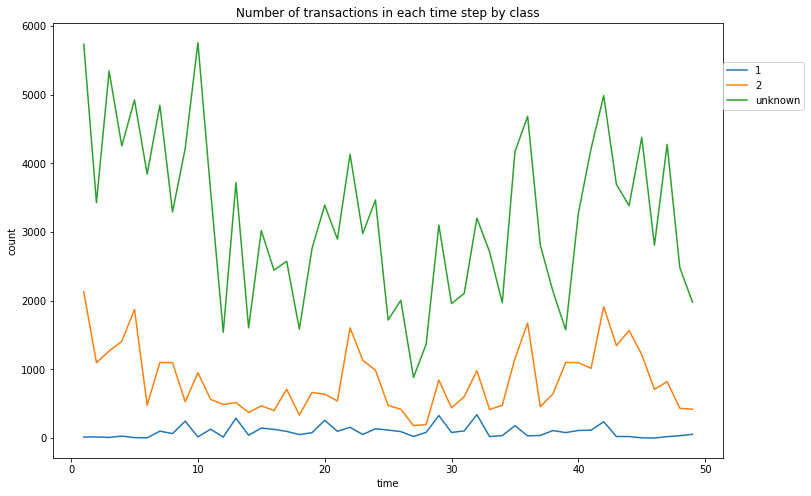

In [9]:
plt.figure(figsize=(12, 8))
grouped = raw_features.groupby(['time', 'class'])['id'].count().reset_index().rename(columns={'id': 'count'})
sns.lineplot(x='time', y='count', hue='class', data=grouped);
plt.legend(loc=(1.0, 0.8));
plt.title('Number of transactions in each time step by class');

In [10]:
#raw_featuress=raw_features.copy()


## Examples of graphs

Let's have a look at a graph at one time step. I'll plot a directed and an indirected graph.

In [11]:
bad_ids = raw_features.loc[(raw_features['time'] == 37) & (raw_features['class'] == '1'), 'id']
short_edges = raw_edgelist.loc[raw_edgelist['txId1'].isin(bad_ids)]

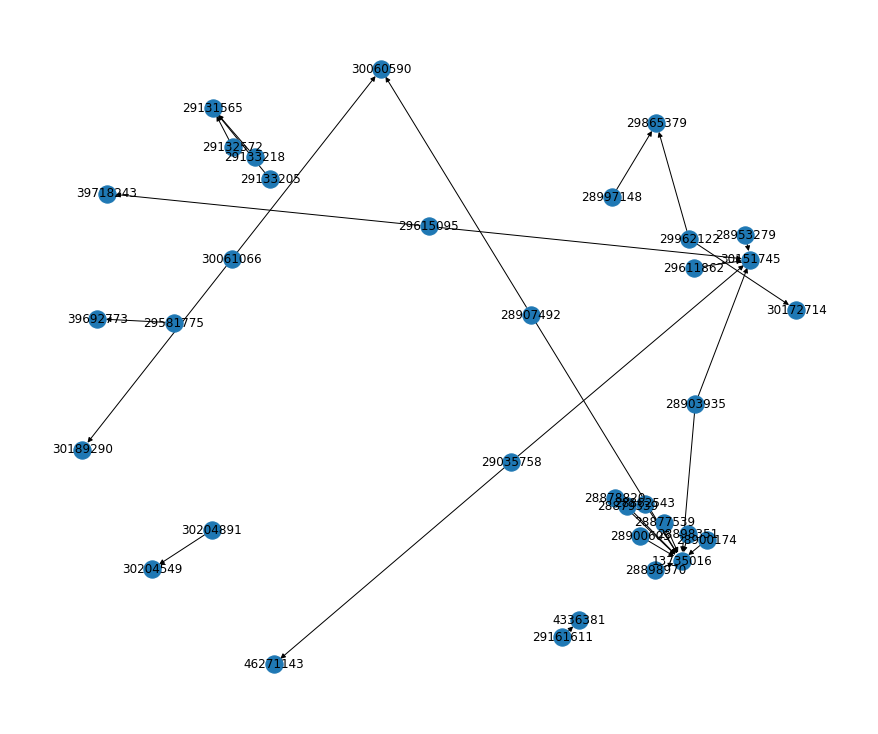

In [12]:
graph = nx.from_pandas_edgelist(short_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos)

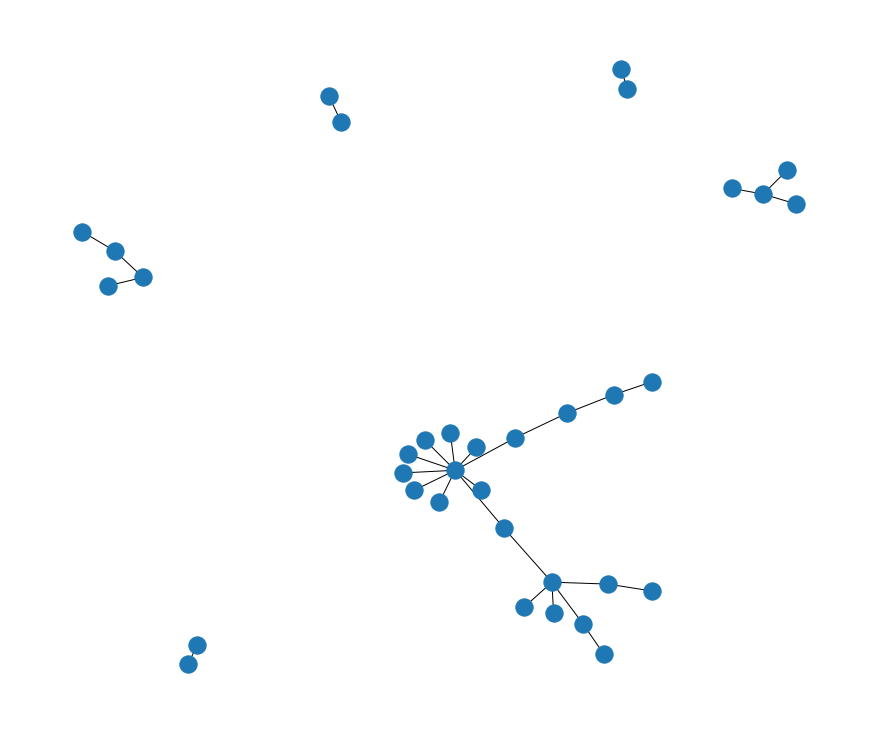

In [13]:
graph1 = nx.from_pandas_edgelist(short_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.Graph())
pos1 = nx.spring_layout(graph1)
nx.draw(graph1, cmap = plt.get_cmap('rainbow'), with_labels=False, pos=pos1)

In [14]:
bad_ids = raw_features.loc[(raw_features['time'] == 37) & (raw_features['class'] == '1'), 'id']
short_edges = raw_edgelist.loc[raw_edgelist['txId1'].isin(bad_ids)]

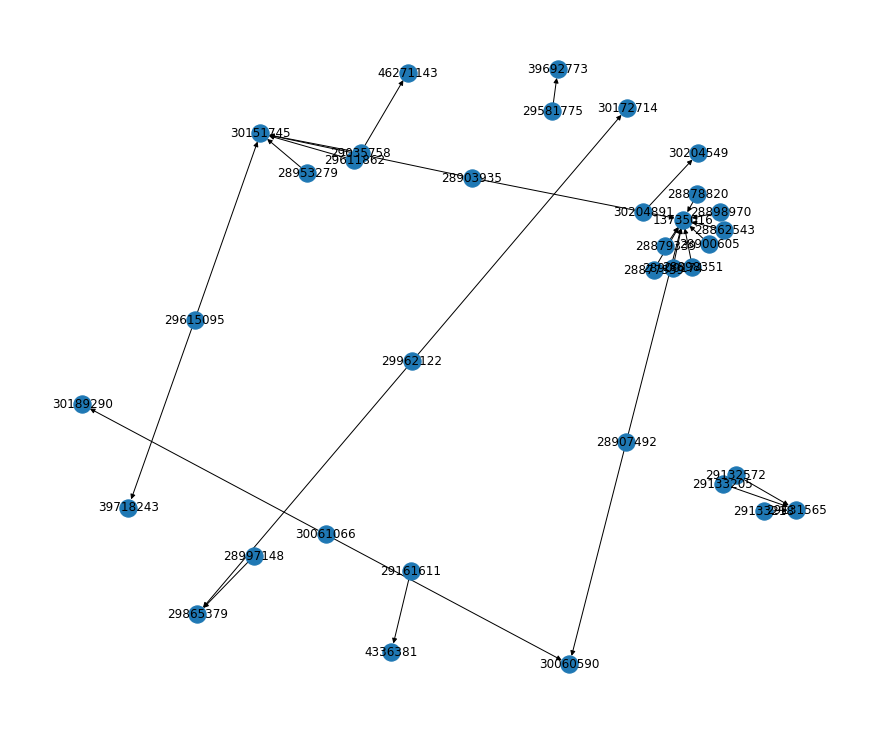

In [15]:
graph = nx.from_pandas_edgelist(short_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos)

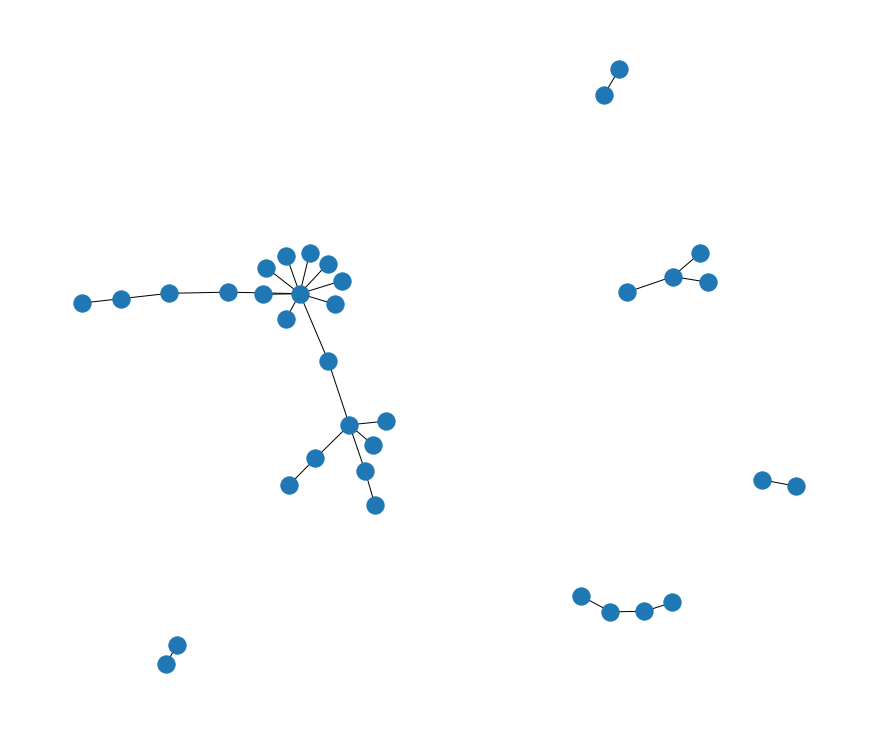

In [16]:
graph1 = nx.from_pandas_edgelist(short_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.Graph())
pos1 = nx.spring_layout(graph1)
nx.draw(graph1, cmap = plt.get_cmap('rainbow'), with_labels=False, pos=pos1)

We can clearly see that some frauders worked alone and some worked in groups.

## features exploration

In [17]:
# grouped = raw_features.groupby(['time step', 'class'])['trans_feat_0'].mean().reset_index()
# chart = alt.Chart(grouped).mark_line().encode(
#     x=alt.X("time step:N", axis=alt.Axis(title='Time step', labelAngle=315)),
#     y=alt.Y('trans_feat_0:Q', axis=alt.Axis(title='Mean of trans_feat_0')),
#     color = 'class:N',
#     tooltip=['time step:O', 'trans_feat_0:Q', 'class:N']
# ).properties(title="Average trans_feat_0 in each time step by type", width=600).interactive()
# chart

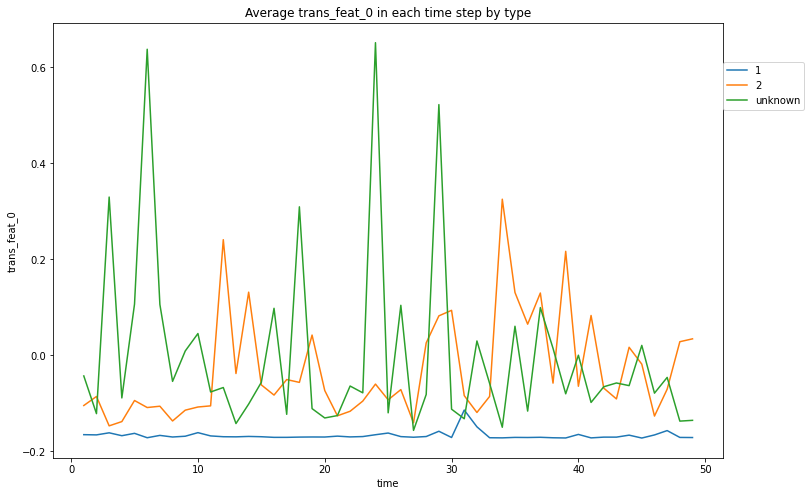

In [18]:
plt.figure(figsize=(12, 8))
grouped = raw_features.groupby(['time', 'class'])['trans_feat_0'].mean().reset_index()
sns.lineplot(x='time', y='trans_feat_0', hue='class', data=grouped);
plt.legend(loc=(1.0, 0.8));
plt.title('Average trans_feat_0 in each time step by type');

We can see that this feature can efficiently separate illicit transactions from licit.

In [19]:
'''plt.figure(figsize=(12, 8))
grouped = raw_features.groupby(['time', 'class'])['trans_feat_1'].mean().reset_index()
sns.lineplot(x='time', y='trans_feat_0', hue='class', data=grouped);
plt.legend(loc=(1.0, 0.8));
plt.title('Average trans_feat_0 in each time step by type');'''

"plt.figure(figsize=(12, 8))\ngrouped = raw_features.groupby(['time', 'class'])['trans_feat_1'].mean().reset_index()\nsns.lineplot(x='time', y='trans_feat_0', hue='class', data=grouped);\nplt.legend(loc=(1.0, 0.8));\nplt.title('Average trans_feat_0 in each time step by type');"

Start 

In [20]:
cleaned_df.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,...,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,txId,class
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,unknown
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,unknown
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,2
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.169472,-0.470592,-0.511871,-0.400422,

In [21]:
cleaned_df =cleaned_df.rename(columns={"class":"Class"})

In [22]:
# You don't want the `Time` column.
cleaned_df.pop('time')
# You don't want the `txId` column.
cleaned_df.pop('txId')
# You don't want the `id` column.
cleaned_df.pop('id')

0           5530458
1         232022460
2         232438397
3         230460314
4         230459870
            ...    
203763    173077460
203764    158577750
203765    158375402
203766    158654197
203767    157597225
Name: id, Length: 203768, dtype: int64

In [23]:
cleaned_df

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,trans_feat_38,trans_feat_39,...,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
0,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown
1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227178,...,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,unknown
2,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,0.026315,-0.227215,...,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
3,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.093120,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.968903,-1.943850,-1.059868

In [24]:
cleaned_df['Class'].replace({"unknown": "-1"}, inplace=True)
cleaned_df['Class'] = pd.to_numeric(cleaned_df['Class'])
y=cleaned_df['Class']


In [25]:
y

0        -1
1        -1
2         2
3        -1
4        -1
         ..
203763   -1
203764   -1
203765    1
203766   -1
203767   -1
Name: Class, Length: 203768, dtype: int64

In [26]:
# You don't want the `id` column.
cleaned_df.pop('Class')
X=cleaned_df

Stating Semi-Supervised Learning With Label Spreading

In [27]:
# evaluate logistic regression fit on label propagation for semi-supervised learning
from numpy import concatenate
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# define dataset
#X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=1)

In [28]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1, stratify=y)



In [29]:
print(X_train[0:4])   
print(X_test[0:4]) 
print(y_train[0:4]) 
print(y_test[0:4])

        trans_feat_0  trans_feat_1  ...  agg_feat_70  agg_feat_71
119013     -0.167326     -0.107012  ...     1.519700     1.521399
179440     -0.136854     -0.047912  ...     1.519700     1.521399
34587       1.423094     -0.132897  ...    -1.760926    -1.760984
149552      0.039420      0.140448  ...    -0.120613    -0.119792

[4 rows x 165 columns]
        trans_feat_0  trans_feat_1  ...  agg_feat_70  agg_feat_71
156107     -0.172631     -0.028288  ...     1.519700     1.521399
165088     -0.170540     -0.016415  ...    -0.120613    -0.119792
20250      -0.166533     -0.153235  ...    -0.242939    -0.187039
116141     -0.153510     -0.023119  ...     1.519700     1.521399

[4 rows x 165 columns]
119013   -1
179440   -1
34587    -1
149552   -1
Name: Class, dtype: int64
156107   -1
165088   -1
20250     2
116141   -1
Name: Class, dtype: int64


In [30]:
# split train into labeled and unlabeled
X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_train, y_train, test_size=0.50, random_state=1, stratify=y_train)



In [31]:
X_train_lab[0:4]

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,trans_feat_38,trans_feat_39,...,agg_feat_32,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
201946,-0.172903,-0.123607,1.018602,-0.12197,-0.043875,-0.113002,-0.061584,-0.163562,-0.169378,-0.049707,-0.165866,-0.028741,-0.035391,-0.042955,-0.013282,-0.057300,-0.171076,-0.172830,-0.176170,-1.373657,-1.371460,-0.139732,-0.148912,-0.080147,-0.155662,-0.010763,-0.012107,-0.139734,-0.148908,-0.080147,-0.155662,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227206,...,-0.097719,0.012845,0.003143,0.002426,-0.123191,-0.197732,-0.185689,-0.211787,-1.159649,-1.160129,1.525218,1.493922,0.483918,1.598791,-0.975738,-0.975237,0.028180,0.338189,0.474451,0.392177,1.301966,1.301281,1.203124,1.192421,0.153209,1.356563,1.488113,1.487932,-0.122129,0.069564,0.229979,0.118049,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
51011,-0.172221,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162866,-0.168692,-0.049707,-0.165171,-0.028741,-0.035391,-0.042955,-0.013282,-0.057182,-0.170383,-0.172044,-0.175363,0.887058,0.884557,-0.139732,-0.148912,-0.080147,-0.155662,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155662,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.097719,-0.127462,0.003143,0.002426,-0.122932,-0.198636,-0.186895,-0.212772,-1.159649,-1.160129,-0.890241,-0.928082,-0.294058,-0.929869,-0.975738,-0.975237,-0.168742,-0.421120,-0.379378,-0.404069,-1.015963,-1.016230,-0.968903,0.669709,1.972826,-0.161217,-1.116918,-1.116948,-0.216814,-0.102304,0.050628,-0.083789,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399
178994,-0.167638,-0.039189,1.018602,-0.12197,-0.043875,-0.113002,-0.061584,-0.158173,-0.164064,-0.049707,-0.160483,-0.028741,-0.035391,-0.042955,-0.013282,-0.047371,-0.166369,-0.168233,-0.169937,-1.373657,-1.371460,-0.139730,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.097719,-0.127462,0.003143,0.002426,-0.120255,-0.198226,-0.186985,-0.211748,-1.159649,-1.160129,1.162615,0.874566,-0.300105,1.076918,1.342003,1.340733,-0.110695,-0.324846,-0.283656,-0.293161,1.301966,1.301281,1.203124,0.669709,-0.453330,1.053007,1.488113,1.487932,-0.216814,-0.599493,-0.554681,-0.594691,1.461330,1.461369,0.018279,0.546917,1.402720,1.323901,1.519700,1.521399
37005,-0.161343,-0.188874,0.463609,-0.12197,-0.043875,-0.113002,-0.061584,-0.151736,-0.157717,-0.049707,-0.154053,-0.028741,-0.035391,-0.042955,-0.013282,-0.042326,-0.160255,-0.161619,-0.162484,0.887058,0.884557,-0.139727,-0.148909,-0.080147,-0.155658,-0.010763,-0.012107,-0.139729,-0.148904,-0.080147,-0.155658,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.097719,-0.127462,0.003143,0.002426,-0.096998,-0.185864,-0.176593,-0.192740,-1.159649,-1.160129,-1.011449,-1.037603,-0.301754,-1.050074,0.183133,0.182748,-0.170420,-0.405066,-0.359111,-0.388991,

In [32]:
X_test_unlab[0:4]

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,trans_feat_38,trans_feat_39,...,agg_feat_32,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
8353,0.139106,-0.132897,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,0.155669,0.145379,-0.049707,0.153009,-0.028741,-0.035391,-0.042955,-0.013282,-0.054666,0.149513,0.195407,0.193215,0.887058,0.884557,-0.139596,-0.148826,-0.080147,-0.155547,-0.010763,-0.012107,-0.139598,-0.148821,-0.080147,-0.155547,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.097719,-0.127462,0.003143,0.002426,-0.109742,-0.052968,-0.004958,-0.042629,1.064205,1.063787,-1.313538,-1.303003,-0.301205,-1.345457,-0.975738,-0.975237,-0.158413,-0.451760,-0.420758,-0.430701,1.301966,1.301281,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.216814,-0.599493,-0.554681,-0.594691,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
19941,-0.170123,-0.069301,1.018602,0.328255,-0.043875,0.222447,0.242712,-0.163643,-0.166593,-0.035722,-0.165531,1.495746,1.936497,-0.042955,-0.013282,-0.048522,-0.168842,-0.170981,-0.172879,0.887058,0.884557,-0.139731,-0.148894,-0.080134,-0.155657,1.714398,2.130234,-0.139733,-0.148889,-0.080133,-0.155657,1.714472,2.130199,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.226903,...,-0.080658,-0.103061,-2.370006,-2.370073,-0.099193,0.084786,0.167534,0.117872,1.064205,1.063787,-1.192601,-1.192982,-0.291585,-1.225106,1.342003,1.340733,-0.114770,-0.016959,0.094362,0.004457,1.301966,1.301281,1.203124,1.192421,0.153209,1.356563,1.488113,1.487932,-0.051116,0.480819,0.708248,0.559569,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
135726,-0.172089,0.181450,1.018602,0.403293,-0.043875,-0.113002,2.068489,-0.163590,-0.169227,-0.048914,-0.165834,1.183663,0.489763,-0.042955,-0.013282,-0.056790,-0.170275,-0.171952,-0.175206,0.887058,0.884557,-0.138364,-0.148039,-0.080147,-0.154503,-0.010763,-0.012107,-0.138365,-0.148035,-0.080147,-0.154503,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.160278,...,-0.097719,-0.127462,0.003143,0.002426,-0.124176,-0.196922,-0.184434,-0.211058,1.064205,1.063787,0.619129,0.413224,-0.257022,0.554474,-0.975738,-0.975237,0.014030,-0.353210,-0.365606,-0.283170,1.301966,1.301281,1.203124,0.146997,-1.059868,0.749451,0.185597,0.185492,-0.003773,-0.531973,-0.539735,-0.468543,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
136908,0.114142,0.373908,1.573595,0.028105,0.372976,0.054722,-0.061584,-0.163476,0.117627,2.081863,-0.068130,2.134314,2.415325,0.382182,-0.013282,-0.057328,0.116462,-0.075543,-0.146706,-0.460499,-0.056473,-0.139731,-0.148833,-0.080056,-0.155626,2.308271,1.326635,-0.139733,-0.148829,-0.080056,-0.155626,2.308337,1.326651,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.071858,-0.085438,1.694205,1.939564,-0.124747,-0.063834,-0.133810,-0.186554,-0.160479,-0.206772,0.679403,0.475912,-0.274364,0.606692,0.388197,0.322143,-0.151059,0.781558,0.587369,0.668249,0.072636,0.079890,-0.968903,0.669709

In [33]:
model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
# define supervised learning model
model.fit(X_train_lab, y_train_lab)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
# fit supervised learning model on entire training dataset
yhat = model.predict(X_test)



In [36]:
# calculate score for test set
score = accuracy_score(y_test, yhat)
# summarize score
print('Accuracy: %.2f' % (score*100))

Accuracy: 85.31
